In [117]:
import re
from urllib.parse import urlparse
import pandas as pd 
import requests
from bs4 import BeautifulSoup

def get_page_link_from_mb(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.text)
    source_row = list(filter(lambda x: x.get_text().startswith('Source:'), soup.find_all('p')))
    if len(source_row) == 0:
        print('None found')
        return url, res.text
    if len(source_row) > 1:
        print('>1 found')
        return url, res.text
    return url, source_row[0].get_text().replace('Source:', '').strip()

# MediaBiasFactCheck

In [2]:
res = requests.get('https://igniparoustempest.github.io/mediabiasfactcheck-bias')
soup = BeautifulSoup(res.text)

In [3]:
rows = soup.find('table').find_all('tr')
header = list(map(lambda x: x.get_text(), rows[0].find_all('th')))
data = []
for r in rows[1:]:
    datum = list(map(lambda x:
                 x.get_text() if x.find('a') is None else x.find('a').attrs['href'], 
                 r.find_all('th')
                )
            )
    data.append(datum)

In [4]:
mediabias_df = pd.DataFrame(data, columns=header)

In [18]:
from tqdm.auto import tqdm

In [43]:
from concurrent.futures import ThreadPoolExecutor

# results = {}
with ThreadPoolExecutor(max_workers=10) as executor:
    for url, res in tqdm(executor.map(
        get_page_link_from_mb, 
#         mediabias_df['Page Link'].tolist()
        to_get.tolist()
    ), total=len(mediabias_df)):
        results[url] = res

  0%|          | 0/2138 [00:00<?, ?it/s]

None found
None found
None found
None found
None found
None found
>1 found
None found
None found
None found
None found
None found
None found
None found


In [44]:
link_df = pd.Series(results).to_frame('page_url')

In [53]:
mediabias_df = mediabias_df.merge(link_df, right_index=True, left_on='Page Link')

In [58]:
mediabias_df= mediabias_df.drop(['Left-Right Spectrum Image', ] ,axis=1)

In [59]:
mediabias_df.to_csv('../data/mediabias-fact-check.csv')

In [61]:
mediabias_df.head(10)

,Name,Factual Reporting,Bias,Estimated Bias Value,Page Link,page_url
0,10News.one,QUESTIONABLE,Extreme Right,46,https://mediabiasfactcheck.com/10news-one/,https://www.10news.one/
1,24 News,QUESTIONABLE,Extreme Right,43,https://mediabiasfactcheck.com/24-news/,http://us24news.com
2,100 Percent Fed Up,QUESTIONABLE,Extreme Right,44,http://mediabiasfactcheck.com/100-percent-fed-up/,https://100percentfedup.com/
3,247 News Media,QUESTIONABLE,Extreme Right,46,http://mediabiasfactcheck.com/247-news-media/,http://247newsmedia.com/
4,70 News (Fake),QUESTIONABLE,Extreme Right,45,https://mediabiasfactcheck.com/70-news/,https://70news.wordpress.com/
5,Activist Mommy,QUESTIONABLE,Extreme Right,46,https://mediabiasfactcheck.com/activist-mommy/,https://elizabethjohnston.org/
6,Age of Shitlords,QUESTIONABLE,Right,39,http://mediabiasfactcheck.com/age-of-shitlords/,https://ageofshitlords.com/
7,Alpha News,QUESTIONABLE,Extreme Right,43,https://mediabiasfactcheck.com/alpha-news/,https://alphanews.org/
8,Allen West Republic,QUESTIONABLE,Extreme Right,45,http://mediabiasfactcheck.com/allen-west-repub...,http://allenwestrepublic.com/
9,Alliance Defending Freedom,QUESTIONABLE,Extreme Right,45,https://mediabiasfactcheck.com/alliance-defend...,https://www.adflegal.org/


In [148]:
mediabias_df.shape 

(2138, 7)

In [ ]:
mediabias_df['page_domain'] = mediabias_df['page_url'].apply(lambda x: urlparse(x).netloc)

# Analyze Headlines

In [82]:
webarchive_pattern = 'http\:\/\/web\.archive\.org\/web\/\d{14}\/'
article_ids = pd.read_csv('../data/multi-news-code-and-ids/data/inputs.txt', sep='\t', header=None)
article_ids.columns=['webarchive_url', 'id']

In [84]:
urls = article_ids['webarchive_url'].apply(lambda x: re.sub(webarchive_pattern, '', x))

In [150]:
urls.shape 

(267250,)

In [151]:
urls.head()

0    http://www.washingtonpost.com/world/national-s...
1    http://www.newser.com/story/136936/iran-to-kil...
2    http://www.newser.com:80/story/220059/authorit...
3    http://www.newser.com/story/59853/pope-benedic...
4    https://www.adn.com/alaska-news/2017/06/19/rea...
Name: webarchive_url, dtype: object

In [89]:
mediabias_df.loc[lambda df: df['Name'].str.contains('Newser')]

,Name,Factual Reporting,Bias,Estimated Bias Value,Page Link,page_url
1039,Newser,HIGH,Left Centre,-12,https://mediabiasfactcheck.com/newser/,https://www.newser.com/


In [115]:
url_domains = urls.apply(lambda x: urlparse(x).netloc)

In [116]:
url_domains = url_domains.str.replace('\:\d+', '', regex=True)

In [118]:
url_domains_with_mediabias = (url_domains
 .to_frame('article_domain')
 .merge(mediabias_df, left_on='article_domain', right_on='page_domain', how='left')
)

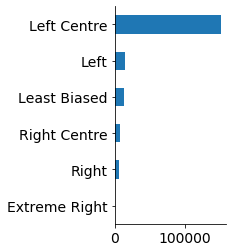

In [135]:
import matplotlib.pyplot as plt
plt.rc('font', size=14)

ax = (
    url_domains_with_mediabias['Bias']
    .value_counts()
    .iloc[::-1]
    .plot(kind='barh', figsize=(2,4))
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

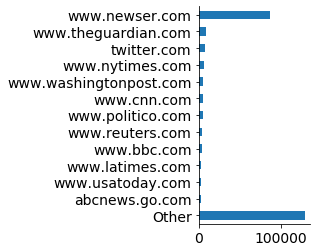

In [146]:
top_k = 12
ax = (   url_domains_with_mediabias['article_domain']
        .value_counts()
        .pipe(lambda s: pd.concat([s[:top_k], pd.Series({'Other': s[top_k:].sum()})]))
        .iloc[::-1]
        .plot(kind='barh', figsize=(2,4))

)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

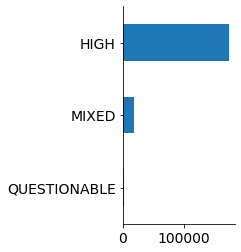

In [147]:
ax = (
    url_domains_with_mediabias['Factual Reporting']
    .value_counts()
    .iloc[::-1]
    .plot(kind='barh', figsize=(2,4))
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)